In [11]:
import numpy as np
import vtk
import matplotlib.pyplot as plt
import os
import netCDF4 as nc
from vtk import vtkUnstructuredGridReader
from vtk import vtkXMLUnstructuredGridReader
from vtk.util import numpy_support as VN
from vtk.util.numpy_support import vtk_to_numpy
from scipy.spatial import KDTree
import pygmt
import pandas
os.chdir("../postprocessing_scripts/")
import MORVEL
import parallel_curves
os.chdir("../supplemental_figures/")

In [12]:
def cartesian_to_spherical(x, y, z):
    """
    Takes an x, y, z and converts it to spherical coordinates. Returns r, theta, phi
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = 90 - np.rad2deg( np.arccos( z / (np.sqrt(x**2 + y**2 + z**2)) ) )
    phi =  np.sign(y) * np.rad2deg(np.arccos( x / np.sqrt(x**2 + y**2) ))
    phi[np.where(phi < 0)] = phi[np.where(phi < 0)] + 360
    phi[np.where(phi == 0)] = 180
    
    return r, phi, theta

def spherical_to_global_cartesian(r, phi, theta):
    """
    Takes spherical coordinates r, theta, and phi and converts to Cartesian coordinates.
    Returns x, y, z
    """
    x = r * np.sin(np.deg2rad(90 - theta)) * np.cos(np.deg2rad(phi))
    y = r * np.sin(np.deg2rad(90 - theta)) * np.sin(np.deg2rad(phi))
    z = r * np.cos(np.deg2rad(90 - theta))
    
    return x, y, z

In [14]:
base_directory = "../ASPECT_models/5e20_10kmweak_dry/"

# trench = np.loadtxt(fname="../data/trench_contour.csv", delimiter=',')[0:270]
profile_directory = "../slab2_worldbuilder_generation/profiles_for_worldbuilder/geographic/"
ASPECT_trench_lon = np.empty(0)
ASPECT_trench_lat = np.empty(0)
for file in np.sort(os.listdir(profile_directory)):
    profile_file = np.loadtxt(fname=profile_directory + file)
    trench_ind = np.where(profile_file[:, 0] == np.max(profile_file[:, 0]))
    ASPECT_trench_lon = np.concatenate( (ASPECT_trench_lon, np.array([profile_file[:, 0][trench_ind][0]])))
    ASPECT_trench_lat = np.concatenate( (ASPECT_trench_lat, np.array([profile_file[:, 1][trench_ind][0]])))
coastline = np.loadtxt(fname='../data/coastline.txt')

solution_dir_path = base_directory + "solution/"
solutions = np.sort(os.listdir( solution_dir_path ))
t_step = 0

pos_solution = np.empty(0)
velocity_total = np.empty(0)
crust_total = np.empty(0)
litho_total = np.empty(0)
east_AUS_total = np.empty(0)
overriding_total = np.empty(0)

for soln in solutions:
    if soln[-4:-1] == '.vt' and soln[9:14] == str(t_step).zfill(5):
        file_path = os.path.join(solution_dir_path, soln)
        reader = vtkXMLUnstructuredGridReader()
        reader.SetFileName(file_path)
        reader.Update()
        data = reader.GetOutput()
        points = data.GetPoints()
        x = vtk_to_numpy(points.GetData())
        velocity = vtk_to_numpy(data.GetPointData().GetArray('velocity'))
        crust = vtk_to_numpy(data.GetPointData().GetArray('Crust'))
        litho = vtk_to_numpy(data.GetPointData().GetArray('Base_Subducting'))
        east_AUS = vtk_to_numpy(data.GetPointData().GetArray('East_Prov_AUS'))
        overriding = vtk_to_numpy(data.GetPointData().GetArray('Base_Continent'))

        if len(pos_solution) == 0:
            pos_solution = x
            velocity_total = velocity
        else:
            pos_solution = np.concatenate( (pos_solution, x) )
            velocity_total = np.concatenate( (velocity_total, velocity) )
        crust_total = np.concatenate( (crust_total, crust) )
        litho_total = np.concatenate( (litho_total, litho) )
        east_AUS_total = np.concatenate( (east_AUS_total, east_AUS) )
        overriding_total = np.concatenate( (overriding_total, overriding) )

litho_points = pos_solution[np.where( (crust_total >= 0.5) | (litho_total >= 0.5) )]
litho_velocity = velocity_total[np.where( (crust_total >= 0.5) | (litho_total >= 0.5) )]
litho_tree = KDTree(np.c_[litho_points[:, 0], litho_points[:, 1], litho_points[:, 2]])

over_points = pos_solution[np.where( (overriding_total >= 0.5) | (east_AUS_total >= 0.5) )]
over_velocity = velocity_total[np.where( (overriding_total >= 0.5) | (east_AUS_total >= 0.5) )]
over_tree = KDTree(np.c_[over_points[:, 0], over_points[:, 1], over_points[:, 2]])

In [39]:
# trench_for_parallel = trench[np.where( (trench[:, 1] >= -44) & (trench[:, 1] <=-26.5) )]
res = parallel_curves.parallel_curves(ASPECT_trench_lon, ASPECT_trench_lat, d=0.1, make_plot=False, flag1=False)
over_trench_x = res['x_inner']
over_trench_y = res['y_inner']
litho_trench_x = res['x_outer']
litho_trench_y = res['y_outer']

In [41]:
over_velocity_profile = np.empty(0)
litho_velocity_profile = np.empty(0)

for i in range(len(over_trench_x)):
    prof_x, prof_y, prof_z = spherical_to_global_cartesian(6361e3, over_trench_x[i], over_trench_y[i])
    dd, ii = over_tree.query([prof_x, prof_y, prof_z])
    if len(over_velocity_profile) == 0:
        over_velocity_profile = over_velocity[ii]
    else:
        over_velocity_profile = np.vstack( (over_velocity_profile, over_velocity[ii]) )

for i in range(len(litho_trench_x)):
    prof_x, prof_y, prof_z = spherical_to_global_cartesian(6361e3, litho_trench_x[i], litho_trench_x[i])
    dd, ii = litho_tree.query([prof_x, prof_y, prof_z])
    if len(litho_velocity_profile) == 0:
        litho_velocity_profile = litho_velocity[ii]
    else:
        litho_velocity_profile = np.vstack( (litho_velocity_profile, litho_velocity[ii]) )

over_spherical_v_profile = MORVEL.velocity_converter(over_trench_y, over_trench_x, over_velocity_profile)
litho_spherical_v_profile = MORVEL.velocity_converter(litho_trench_y, litho_trench_x, litho_velocity_profile)

over_v_mag = np.zeros(len(over_spherical_v_profile))
over_azimuths = np.zeros(len(over_spherical_v_profile))
for i in range(len(over_v_mag)):
    over_v_mag[i] = np.sqrt(over_spherical_v_profile[i][0]**2 + over_spherical_v_profile[i][1]**2 + over_spherical_v_profile[i][2]**2) * 100
    over_azimuths[i] = np.rad2deg(np.arctan(over_spherical_v_profile[i][2]/over_spherical_v_profile[i][1]))
    if np.sign(over_spherical_v_profile[i][2]) >= 0:
        if np.sign(over_spherical_v_profile[i][1]) >= 0:
            over_azimuths[i] = -over_azimuths[i]
            over_azimuths[i] += 90
        elif np.sign(over_spherical_v_profile[i][1]) < 0:
            over_azimuths[i] = over_azimuths[i]
            over_azimuths[i] += 90
    elif np.sign(over_spherical_v_profile[i][2]) < 0:
        if np.sign(over_spherical_v_profile[i][1]) < 0:
            over_azimuths[i] = -over_azimuths[i]
            over_azimuths[i] += 270
        elif np.sign(over_spherical_v_profile[i][1]) >= 0:
            over_azimuths[i] = over_azimuths[i]
            over_azimuths[i] += 270

litho_v_mag = np.zeros(len(over_spherical_v_profile))
litho_azimuths = np.zeros(len(over_spherical_v_profile))
for i in range(len(litho_v_mag)):
    litho_v_mag[i] = np.sqrt(litho_spherical_v_profile[i][0]**2 + litho_spherical_v_profile[i][1]**2 + litho_spherical_v_profile[i][2]**2) * 100
    litho_azimuths[i] = np.rad2deg(np.arctan(litho_spherical_v_profile[i][2]/litho_spherical_v_profile[i][1]))
    if np.sign(litho_spherical_v_profile[i][2]) >= 0:
        if np.sign(litho_spherical_v_profile[i][1]) >= 0:
            litho_azimuths[i] = -litho_azimuths[i]
            litho_azimuths[i] += 90
        elif np.sign(litho_spherical_v_profile[i][1]) < 0:
            litho_azimuths[i] = litho_azimuths[i]
            litho_azimuths[i] += 90
    elif np.sign(litho_spherical_v_profile[i][2]) < 0:
        if np.sign(litho_spherical_v_profile[i][1]) < 0:
            litho_azimuths[i] = -litho_azimuths[i]
            litho_azimuths[i] += 270
        elif np.sign(litho_spherical_v_profile[i][1]) >= 0:
            litho_azimuths[i] = litho_azimuths[i]
            litho_azimuths[i] += 270

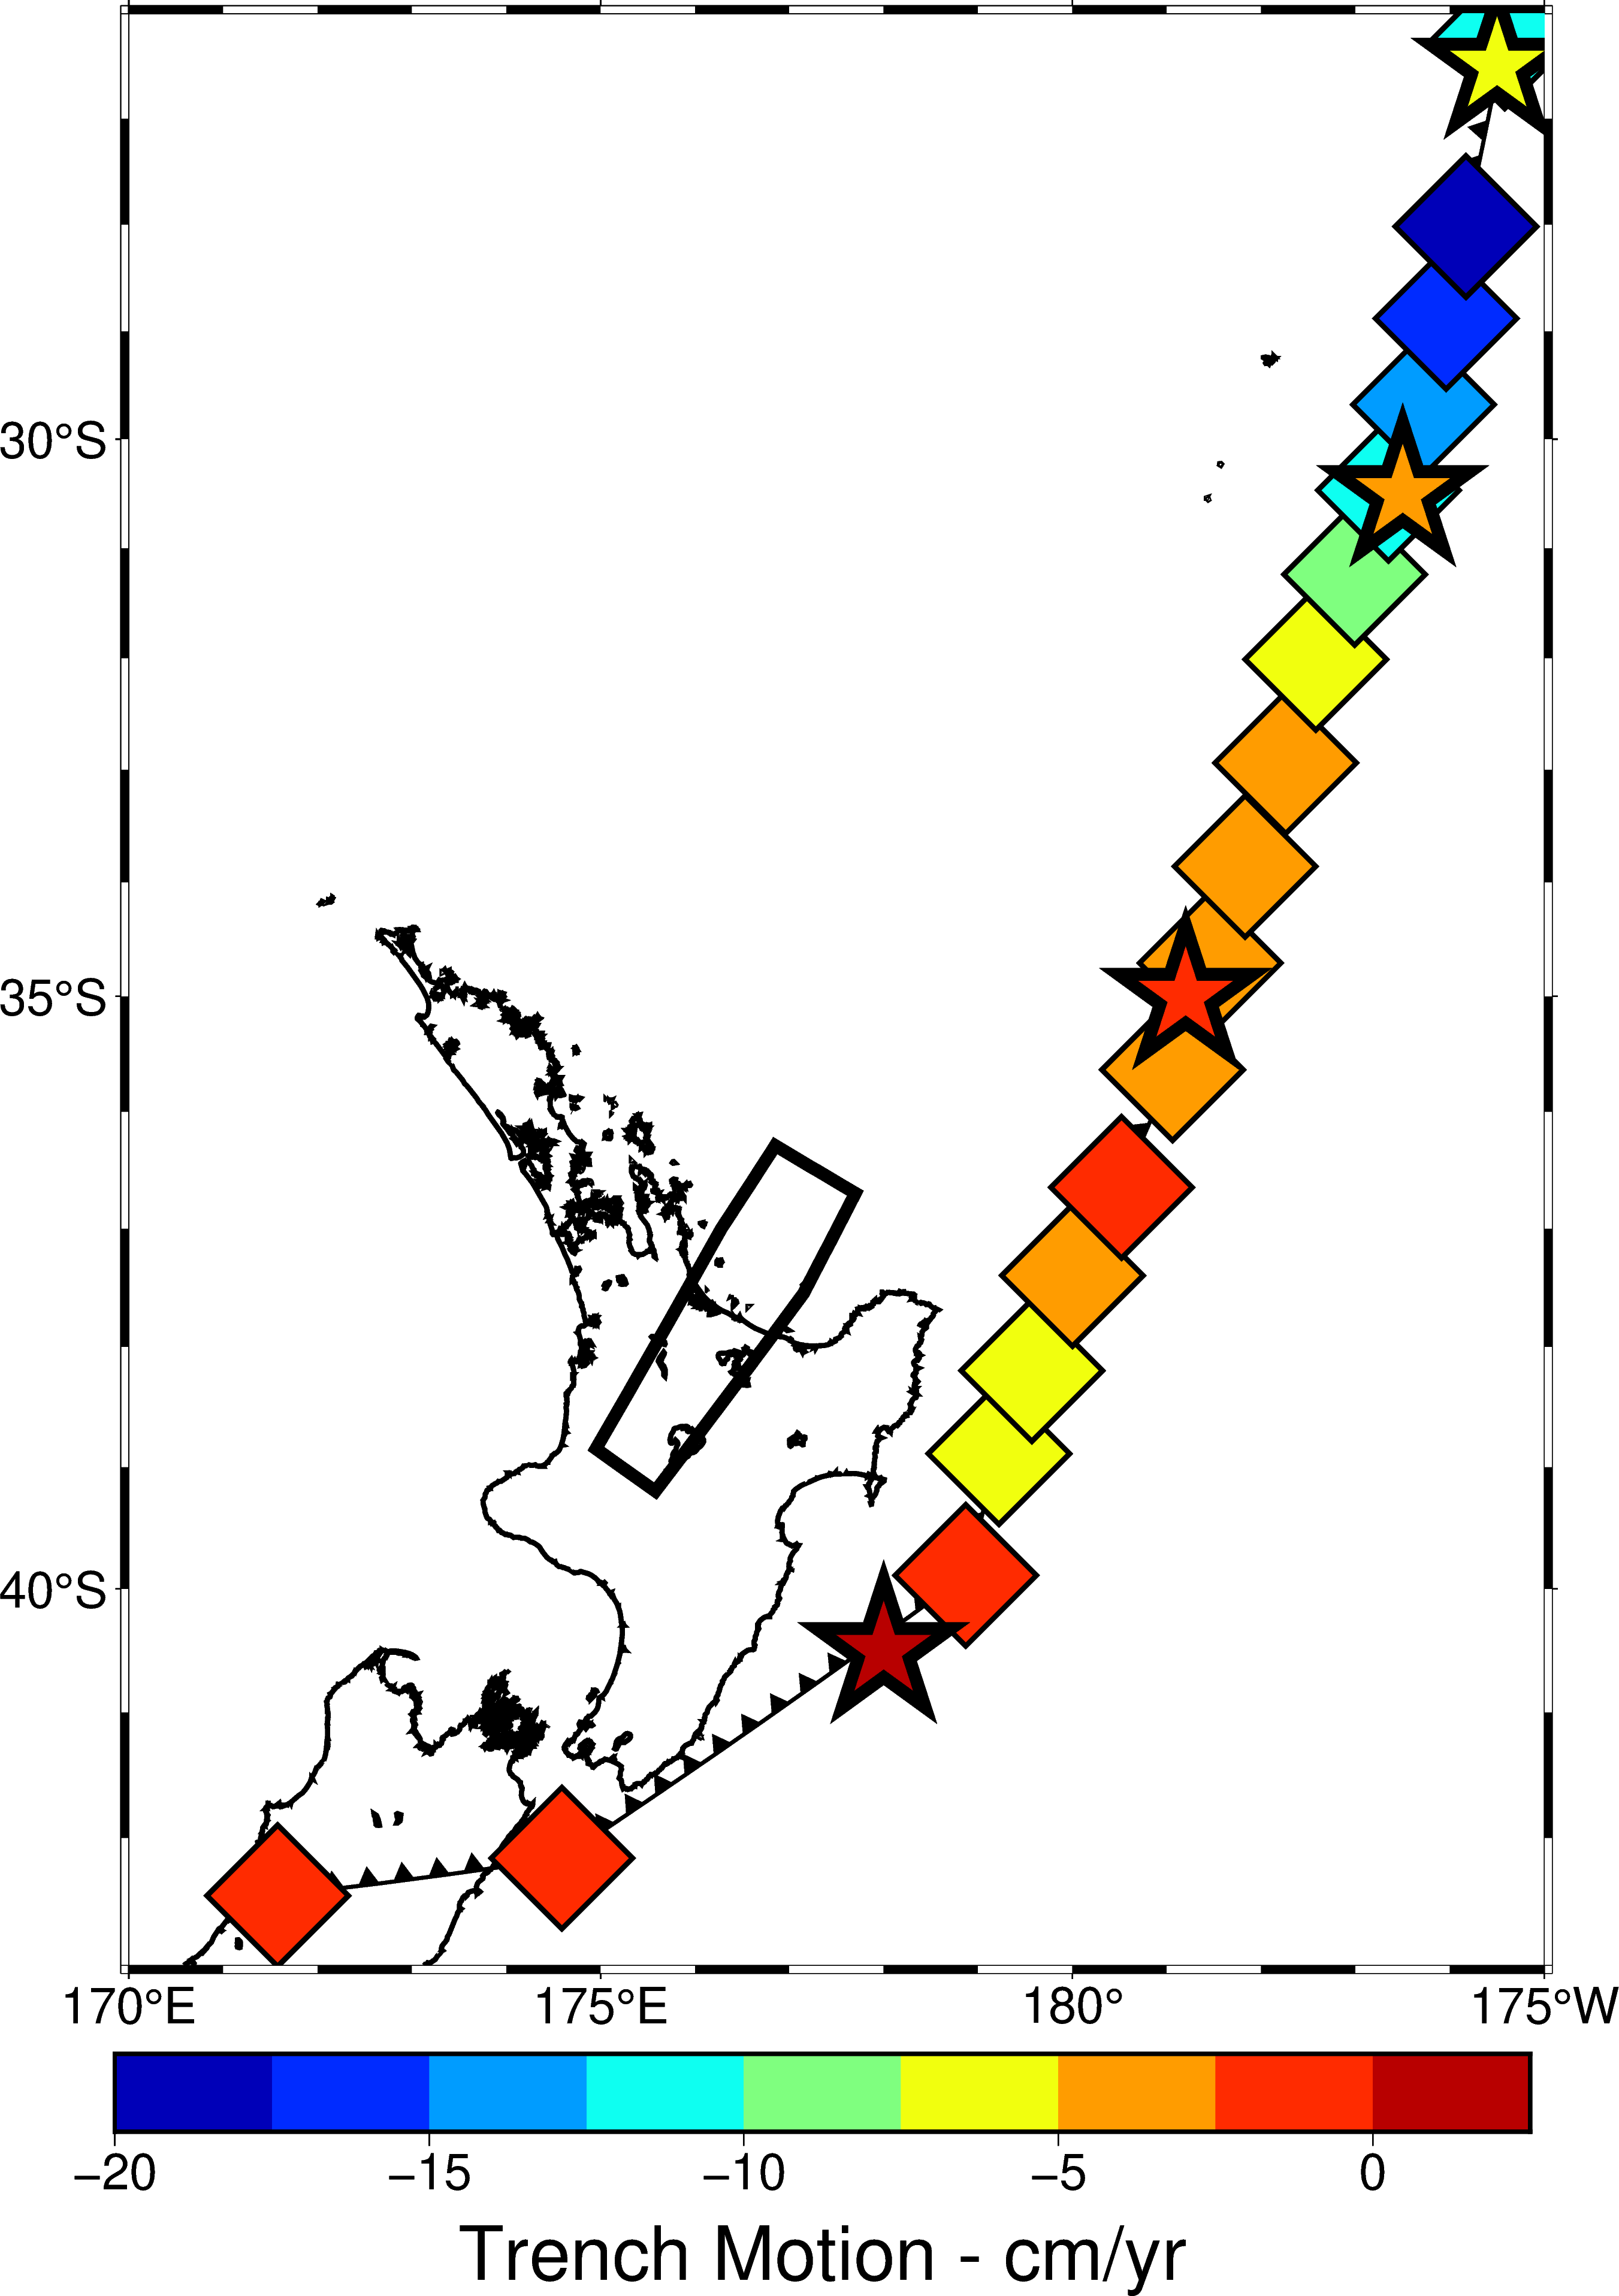

In [86]:
trench_motion = (litho_v_mag - over_v_mag)
plot_region = [170, 185, -43, -26]

schellart_lon = np.array([178, 181.2, 183.5, 184.5])

schellart_lat = np.array([-40.5, -35, -30.5, -26.5])

schellart_mag = np.array([2.1, -0.9, -3.2, -5.4])

schellart_digitized = np.array([])
# grid = pygmt.datasets.load_earth_relief(resolution="01m", region=large_region)
fig = pygmt.Figure()
pygmt.config(FONT_LABEL='30p', MAP_LABEL_OFFSET='0.5', FONT_ANNOT_PRIMARY='20p')

fig.basemap(region=plot_region, projection="M20c", frame=["af"])

fig.coast(shorelines="2p,black")
fig.plot(x=ASPECT_trench_lon, y=ASPECT_trench_lat, pen="1.5p", style="f0.5c/0.3c+l+t+o0.3c+p", fill='black')

pygmt.makecpt(cmap="jet", series=[-20, 2.5, 2.5])
fig.plot(
    x=ASPECT_trench_lon,
    y=ASPECT_trench_lat,
    size=2 + trench_motion*0,
    fill=trench_motion,
    cmap=True,
    style="d",
    pen="2p,black",
)

fig.plot(
    x=schellart_lon,
    y=schellart_lat,
    size=2 + schellart_mag*0,
    fill=schellart_mag,
    cmap=True,
    style="a",
    pen="5p,black",
)

fig.colorbar(position="JBC+o-0.2c/1.25c+w20c/1.1c+h", frame=["a5", "x+lTrench Motion - cm/yr"])

fig.show()
fig.savefig('trench_motion.png')